Project Task 1 - Basic Classifiers and Evaluation

1) Prepare the dataset in order to build several basic classifiers able to predict room occupancy from the available variables. You are welcome in creating new variables.

2) Solve the classification task with k-NN (testing values of k), Naive Bayes, Logistic Regression, Decision Tree using cross-validation and/or random/grid search for parameter estimation.

3) Evaluate each classifier using Accuracy, Precision, Recall, F1, ROC, AUC and Lift Chart.

4) Try to reduce the dimensionality of the dataset using the methods studied (or new ones). Test PCA and try to solve the classification task in two dimensions. Plot the dataset in the two new dimensions and observe the decision boundary and the one of the trained algorithms.

5) Analyze the value distribution of the class to predict and turn the dataset into an imbalanced version reaching a strong majority-minority distribution (e.g. 96%-4%). Then solve again the classification task adopting the various techniques studied (or new ones).

6) Select two continuous attributes, define a regression problem and try to solve it using different techniques reporting various evaluation measures. Plot the two-dimensional dataset. Then generalize to multiple linear regression and observe how the performance varies.

7) Draw your conclusions about the basic classifiers and techniques adopted in this analysis.


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
df_test1 = pd.read_csv("datatest.txt")

In [3]:
df_test2 = pd.read_csv("datatest2.txt")

In [4]:
df = pd.read_csv("datatraining.txt")

In [65]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [66]:
df.head()

,Temperature,Humidity,Light,CO2,Occupancy,day,hour,weekend,daylight
0,1.000000,0.470533,0.275490,0.190933,1.0,0.0,0.73913,0.0,1.0
1,0.992823,0.470332,0.277754,0.186446,1.0,0.0,0.73913,0.0,1.0
2,0.992823,0.469326,0.275490,0.186136,1.0,0.0,0.73913,0.0,1.0
3,0.992823,0.467315,0.275490,0.182887,1.0,0.0,0.73913,0.0,1.0
4,0.980861,0.467315,0.275490,0.180566,1.0,0.0,0.73913,0.0,1.0


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8142 entries, 0 to 8141
Data columns (total 9 columns):
Temperature    8142 non-null float64
Humidity       8142 non-null float64
Light          8142 non-null float64
CO2            8142 non-null float64
Occupancy      8142 non-null float64
day            8142 non-null float64
hour           8142 non-null float64
weekend        8142 non-null float64
daylight       8142 non-null float64
dtypes: float64(9)
memory usage: 572.6 KB


In [68]:
dates = pd.to_datetime(df['date'], infer_datetime_format=True)
df['day'] = dates.dt.day
df['hour'] = dates.dt.hour

KeyError: 'date'

In [69]:
weekend = []
for i in df.day:
    if i == 7 or i == 8:
        weekend.append(1)
    else:
        weekend.append(0)
weekend = pd.Series(weekend)
df['weekend'] = weekend

In [70]:
daylight = []
for i in df.hour:
    if i >= 7 and i <= 17:
        daylight.append(1)
    else:
        daylight.append(0)
daylight = pd.Series(daylight)
df['daylight'] = daylight

In [71]:
df.head()


,Temperature,Humidity,Light,CO2,Occupancy,day,hour,weekend,daylight
0,1.000000,0.470533,0.275490,0.190933,1.0,0.0,0.73913,0,0
1,0.992823,0.470332,0.277754,0.186446,1.0,0.0,0.73913,0,0
2,0.992823,0.469326,0.275490,0.186136,1.0,0.0,0.73913,0,0
3,0.992823,0.467315,0.275490,0.182887,1.0,0.0,0.73913,0,0
4,0.980861,0.467315,0.275490,0.180566,1.0,0.0,0.73913,0,0


# DATA PARTITIONING

In [73]:
# Remove "date" from dataset because gives us an error
df = df[['Temperature', 'Humidity', 'Light', 'CO2', 'Occupancy', 'day',
       'hour', 'weekend', 'daylight']]

In [74]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [75]:
class_name = "Occupancy"

In [146]:
prepare_dataset(df, class_name)

(      Temperature  Humidity     Light       CO2  day      hour  weekend  \
 0        1.000000  0.470533  0.275490  0.190933  0.0  0.739130      0.0   
 1        0.992823  0.470332  0.277754  0.186446  0.0  0.739130      0.0   
 2        0.992823  0.469326  0.275490  0.186136  0.0  0.739130      0.0   
 3        0.992823  0.467315  0.275490  0.182887  0.0  0.739130      0.0   
 4        0.980861  0.467315  0.275490  0.180566  0.0  0.739130      0.0   
 5        0.980861  0.467315  0.270964  0.178400  0.0  0.739130      0.0   
 6        0.980861  0.467315  0.270964  0.178813  0.0  0.739130      0.0   
 7        0.980861  0.467315  0.270964  0.177162  0.0  0.739130      0.0   
 8        0.980861  0.467315  0.270964  0.171180  0.0  0.739130      0.0   
 9        0.974880  0.466197  0.270964  0.170354  0.0  0.782609      0.0   
 10       0.974880  0.465080  0.270964  0.171747  0.0  0.782609      0.0   
 11       0.980861  0.462845  0.270964  0.172211  0.0  0.782609      0.0   
 12       0.

In [147]:
remove_missing_values(df)

,Temperature,Humidity,Light,CO2,Occupancy,day,hour,weekend,daylight
0,1.000000,0.470533,0.275490,0.190933,1.0,0.0,0.739130,0.0,0.0
1,0.992823,0.470332,0.277754,0.186446,1.0,0.0,0.739130,0.0,0.0
2,0.992823,0.469326,0.275490,0.186136,1.0,0.0,0.739130,0.0,0.0
3,0.992823,0.467315,0.275490,0.182887,1.0,0.0,0.739130,0.0,0.0
4,0.980861,0.467315,0.275490,0.180566,1.0,0.0,0.739130,0.0,0.0
5,0.980861,0.467315,0.270964,0.178400,1.0,0.0,0.739130,0.0,0.0
6,0.980861,0.467315,0.270964,0.178813,1.0,0.0,0.739130,0.0,0.0
7,0.980861,0.467315,0.270964,0.177162,1.0,0.0,0.739130,0.0,0.0
8,0.980861,0.467315,0.270964,0.171180,1.0,0.0,0.739130,0.0,0.0
9,0.974880,0.466197,0.270964,0.170354,1.0,0.0,0.782609,0.0,0.0


In [148]:
numeric_columns = get_numeric_columns(df)

In [149]:
get_real_feature_names(rdf, numeric_columns, class_name)

['Temperature',
 'Humidity',
 'Light',
 'CO2',
 'day',
 'hour',
 'weekend',
 'daylight']

In [150]:
one_hot_encoding(df, class_name)

(      Temperature  Humidity     Light       CO2  day      hour  weekend  \
 0        1.000000  0.470533  0.275490  0.190933  0.0  0.739130      0.0   
 1        0.992823  0.470332  0.277754  0.186446  0.0  0.739130      0.0   
 2        0.992823  0.469326  0.275490  0.186136  0.0  0.739130      0.0   
 3        0.992823  0.467315  0.275490  0.182887  0.0  0.739130      0.0   
 4        0.980861  0.467315  0.275490  0.180566  0.0  0.739130      0.0   
 5        0.980861  0.467315  0.270964  0.178400  0.0  0.739130      0.0   
 6        0.980861  0.467315  0.270964  0.178813  0.0  0.739130      0.0   
 7        0.980861  0.467315  0.270964  0.177162  0.0  0.739130      0.0   
 8        0.980861  0.467315  0.270964  0.171180  0.0  0.739130      0.0   
 9        0.974880  0.466197  0.270964  0.170354  0.0  0.782609      0.0   
 10       0.974880  0.465080  0.270964  0.171747  0.0  0.782609      0.0   
 11       0.980861  0.462845  0.270964  0.172211  0.0  0.782609      0.0   
 12       0.

In [151]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# k Nearest Neighbor

In [123]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [124]:
#standardizzazione
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns)

#knee method per la scelta numero di k
accuracy_list = list()
f1_list = list()
max_k = 100
for k in range(2, max_k+1):
    print('\rFitting {0} knn'.format(k), end='')
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)
    f1_list.append(f1_score(y_test, y_pred, average=None))

Fitting 100 knn

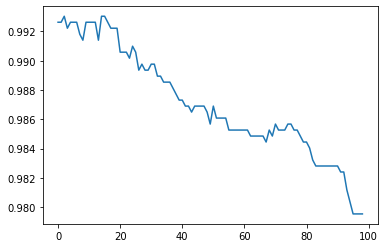

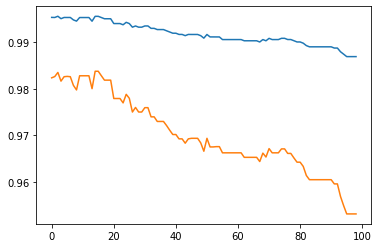

In [125]:
plt.plot(accuracy_list)
plt.show()
plt.plot(f1_list)
plt.show()

In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier()
params = {
    'n_neighbors' : [10, 100],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto']
}
grid_kn = GridSearchCV(estimator = kn,
                        param_grid = params,
                        scoring = 'accuracy', 
                        cv = 5, 
                        verbose = 1,
                        n_jobs = -1)
grid_kn.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'algorithm': ['auto'], 'n_neighbors': [10, 100],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [127]:
# extract best estimator
print(grid_kn.best_estimator_)
clf = KNeighborsClassifier(algorithm='auto', 
leaf_size=30, metric='minkowski',metric_params=None, n_jobs=-1, n_neighbors=25, p=2, weights='distance')
# to test the bestfit
print(grid_kn.score(X_test, y_test))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')
0.9938600081866558


In [128]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=25, p=2,
                     weights='distance')

In [129]:
y_pred = clf.predict(X_test)

In [130]:
clf = KNeighborsClassifier(n_neighbors=25, weights='uniform')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9901760130986492
F1-score [0.9937565  0.97696737]
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1925
         1.0       0.97      0.98      0.98       518

    accuracy                           0.99      2443
   macro avg       0.98      0.99      0.99      2443
weighted avg       0.99      0.99      0.99      2443



In [131]:
scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.9371 (+/- 0.091)
F1-score: 0.9231 (+/- 0.099)


In [132]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [133]:
parameters = {'n_neighbors': np.arange(1, 50 + 1), 'weights':['uniform', 'distance']}

knn = KNeighborsClassifier()
search = GridSearchCV(knn, parameters)
search.fit(X_train, y_train)

C:\Users\pasqu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [134]:
clf = search.best_estimator_

In [135]:
print(clf)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')


In [136]:
from sklearn import datasets
from matplotlib.colors import ListedColormap

n_neighbors = 4


# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = df.Light
y = df.CO2


h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)
    

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[0.27549041 0.27775383 0.27549041 ... 0.28001725 0.28001725 0.28001725].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# NAIVE BAYES

In [152]:
from sklearn.naive_bayes import GaussianNB

In [153]:
 from sklearn.naive_bayes import CategoricalNB

ImportError: cannot import name 'CategoricalNB' from 'sklearn.naive_bayes' (C:\Users\pasqu\Anaconda3\lib\site-packages\sklearn\naive_bayes.py)

In [154]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [155]:
y_pred = clf.predict(X_test)

In [156]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9758493655341793
F1-score [0.98445323 0.94592117]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      1925
         1.0       0.90      1.00      0.95       518

    accuracy                           0.98      2443
   macro avg       0.95      0.98      0.97      2443
weighted avg       0.98      0.98      0.98      2443



In [157]:
X_train_num, X_test_num, y_train, y_test = train_test_split(
    df[[c for c in df.columns if c != class_name]], df[class_name], 
       test_size=0.3, random_state=100, stratify=df[class_name])

In [158]:
clf = GaussianNB()
clf.fit(X_train_num, y_train)
y_pred = clf.predict(X_test_num)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9758493655341793
F1-score [0.98445323 0.94592117]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      1925
         1.0       0.90      1.00      0.95       518

    accuracy                           0.98      2443
   macro avg       0.95      0.98      0.97      2443
weighted avg       0.98      0.98      0.98      2443



In [159]:
rdf[[c for c in rdf.columns if c not in df.columns]].head()

""
0
1
2
3
4


In [160]:
from sklearn.preprocessing import LabelEncoder

rdf_en = rdf[[c for c in rdf.columns if c not in df.columns]].apply(LabelEncoder().fit_transform)
rdf_en.head()

Series([], dtype: float64)

In [161]:
X_train_cat, X_test_cat, y_train, y_test = train_test_split(
    rdf_en[[c for c in rdf_en.columns if c not in numeric_columns]], df[class_name], 
       test_size=0.3, random_state=100, stratify=df[class_name])

AttributeError: 'Series' object has no attribute 'columns'

In [162]:
clf = CategoricalNB()
clf.fit(X_train_cat, y_train)

NameError: name 'CategoricalNB' is not defined

In [163]:
y_pred = clf.predict(X_test_cat)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

NameError: name 'X_test_cat' is not defined